GeekBrains, факультет Искусственного интелекта
курс "Фреймворк PyTorch для разработки искусственных нейронных сетей" (17 мая 2023 - 15 июня 2023)

## Урок 10. Распознавание лиц и эмоций.

### Задание по итогам курса:

__упрощенное/для тех, у кого нет вебкамеры__<br>
Нужно написать приложение, которое будет получать на вход изображение.
В процессе определять, что перед камерой находится человек, задетектировав его лицо на кадре.
На изображении человек показывает жесты руками, а алгоритм должен считать их и классифицировать.

__более сложное__ <br>
Нужно написать приложение, которое будет считывать и выводить кадры с веб-камеры.
В процессе считывания определять что перед камерой находится человек, задетектировав его лицо на кадре.
Человек показывает жесты руками, а алгоритм должен считать их и классифицировать.

Нужно написать приложение, которое будет считывать и выводить кадры с веб-камеры.
В процессе считывания определять что перед камерой находится человек, задетектировав его лицо на кадре.
Человек показывает жесты руками, а алгоритм должен считать их и классифицировать.
Для распознавания жестов, вам надо будет скачать датасет https://www.kaggle.com/gti-upm/leapgestrecog, разработать модель для обучения и обучить эту модель.
Как работать с веб-камерой на google colab https://stackoverflow.com/questions/54389727/opening-web-camera-in-google-colab
У кого нет возможности работать через каггл (нет верификации), то можете данные взять по ссылке: https://disk.yandex.ru/d/R2PGlaXDf6_HzQ

In [1]:
!pip install opendatasets

In [2]:
import pandas

In [4]:
import os
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torchvision import models
from torch.utils.data import DataLoader, ConcatDataset
import torchvision.transforms as tt
import torchvision.transforms.functional as TF
from torchvision.utils import make_grid
#from torchsummary import summary
import matplotlib.pyplot as plt
%matplotlib inline
import time
from torch.autograd import Variable
import cv2
from PIL import Image

In [5]:
!pip install torchsummary

In [6]:
from torchsummary import summary

In [46]:
DATA_ROOT = 'Hand Gesture Recognition Database/leapGestRecog'

Зададим трансформации для трейна и теста. Для Grayscale задаем число выходных слоев, равное 3, т.к. resnet не принимает одноканальные изображения

In [47]:
train_tfms = tt.Compose([
                         tt.Grayscale(num_output_channels=3), # Картинки черно-белые
                         tt.Resize([128, 128]),
                         # Настройки для расширения датасета
                         tt.RandomHorizontalFlip(),           # Случайные повороты на 90 градусов
                         tt.RandomRotation(30),               # Случайные повороты на 30 градусов
                         tt.ToTensor(),                       # Приведение к тензору
                         ])                      

test_tfms = tt.Compose([
                        tt.Grayscale(num_output_channels=3),
                        tt.Resize([128, 128]),
                        tt.ToTensor(),
                        ])
     

Сохраним имена классов через загрузку одной из папок:

In [48]:
tmp_ds = ImageFolder(os.path.join(DATA_ROOT, '00'))
CLASSES_NAME = tmp_ds.classes
CLASSES_NAME

['01_palm',
 '02_l',
 '03_fist',
 '04_fist_moved',
 '05_thumb',
 '06_index',
 '07_ok',
 '08_palm_moved',
 '09_c',
 '10_down']

Создадим тренировочный и тестовый датасеты с одними и теми же картинками, но с разным препроцессингом:

In [49]:
train_ds_list = []
test_ds_list = []
for dir in os.listdir(DATA_ROOT):
  train_ds = ImageFolder(os.path.join(DATA_ROOT, dir), train_tfms)
  test_ds = ImageFolder(os.path.join(DATA_ROOT, dir), test_tfms)
  train_ds_list.append(train_ds)
  test_ds_list.append(test_ds)

train_ds = ConcatDataset(train_ds_list)
test_ds = ConcatDataset(test_ds_list)

Общее количество картинок:

In [50]:
LEN_DS = len(train_ds)
LEN_DS

20000

In [51]:
def digit_to_classname(digit):
  for idx, itm in enumerate(CLASSES_NAME):
    if idx == digit:
      return itm

Посмотрим распределения классов в датасете:

In [52]:
from collections import Counter
tmp_list = []
for _, cls in train_ds:
  tmp_list.append(digit_to_classname(cls))
cnt = Counter(tmp_list)
print(dict(cnt))

{'01_palm': 2000, '02_l': 2000, '03_fist': 2000, '04_fist_moved': 2000, '05_thumb': 2000, '06_index': 2000, '07_ok': 2000, '08_palm_moved': 2000, '09_c': 2000, '10_down': 2000}


Разделим датасет на тренировочный и тестовый:

In [53]:
torch.manual_seed(1)

val_split = 0.2
split = int(LEN_DS * val_split)
indices = torch.randperm(LEN_DS)

train_ds = torch.utils.data.Subset(train_ds, indices[split:])
test_ds = torch.utils.data.Subset(test_ds, indices[:split])

len(train_ds), len(test_ds)

(16000, 4000)

Проверим размерность случайного тензора в датасете:

In [54]:
train_ds[15000][0].size()

torch.Size([3, 128, 128])

Проверим дисбаланс классов:

In [55]:
from collections import Counter
tmp_list = []
for _, cls in train_ds:
  tmp_list.append(digit_to_classname(cls))
cnt = Counter(tmp_list)
print(dict(cnt))

{'05_thumb': 1608, '02_l': 1609, '01_palm': 1587, '06_index': 1606, '04_fist_moved': 1610, '03_fist': 1590, '09_c': 1610, '07_ok': 1594, '08_palm_moved': 1594, '10_down': 1592}


Дисбаланс классов есть, но он очень не существенный

Создадим даталоадеры:

In [57]:
batch_size = 64
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2)
test_dl = DataLoader(test_ds, batch_size, num_workers=1, shuffle=False)

Выведем случайное изображение в тестовом загрузчике:

torch.Size([3, 128, 128])
tensor(3) 04_fist_moved


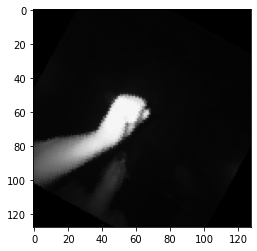

In [58]:
for img, l in train_dl:
    print(img[0].shape)
    print(l[0], digit_to_classname(l[0]))
    plt.imshow(img[0].permute(1, 2, 0)) #, cmap='gray')
    break

Функция для визуалиции батча:

In [59]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        print(images[0].shape)
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

Визуализируем батч:

torch.Size([3, 128, 128])


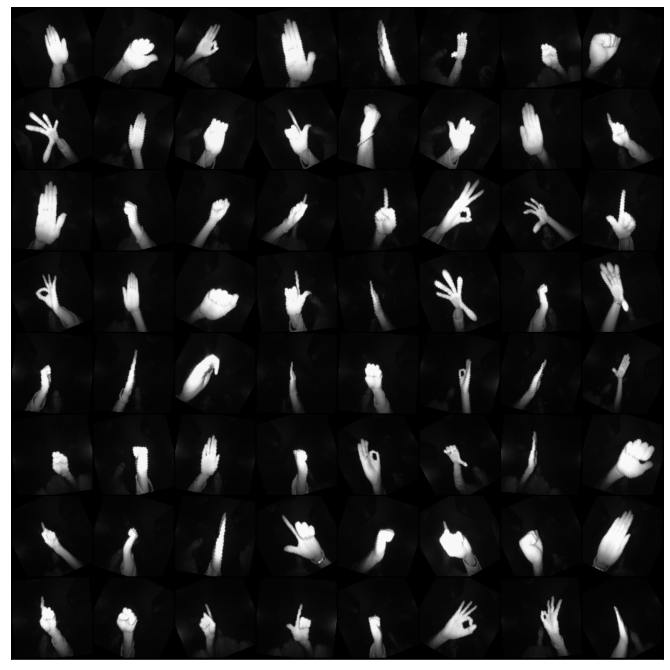

In [60]:
show_batch(train_dl)

In [61]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

Возьмем для классификации предобученную сеть resnet50:

In [73]:
resnet = models.resnet50(pretrained=True)
summary(resnet.to(device), input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]           4,096
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
           Conv2d-11          [-1, 256, 32, 32]          16,384
      BatchNorm2d-12          [-1, 256, 32, 32]             512
           Conv2d-13          [-1, 256, 32, 32]          16,384
      BatchNorm2d-14          [-1, 256,

Запретим весам обучаться

In [74]:
for param in resnet.parameters():
    param.requires_grad = False

Посмотрим на слои нейросети. Нас интересует последний классификационный слой, который мы будем переобучать:

In [75]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Перезапишем последний классификационный слой, и убедимся, что остальные слои не будут обучаться:

In [76]:
in_features = resnet.fc.in_features
fc = nn.Linear(in_features=in_features, out_features=len(CLASSES_NAME))
resnet.fc = fc

summary(resnet.to(device), input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]           4,096
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
           Conv2d-11          [-1, 256, 32, 32]          16,384
      BatchNorm2d-12          [-1, 256, 32, 32]             512
           Conv2d-13          [-1, 256, 32, 32]          16,384
      BatchNorm2d-14          [-1, 256,

Создадим список обучаемых параметров и подадим его в оптимизатор. Также инициализируем функцию потерь:

In [77]:
params_to_update = []
for name, param in resnet.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

        
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params_to_update, lr=0.001)

Инициализируем функцию для обучения сети:

In [78]:
from time import time
# from tqdm import tqdm

def train(model,
          criterion,
          optimizer,
          train_dataloader,
          test_dataloader,
          print_every,
          num_epoch):
    steps = 0
    train_losses, val_losses = [], []

    model.to(device)
    for epoch in range(num_epoch):
        running_loss = 0
        correct_train = 0
        total_train = 0
        start_time = time()
        iter_time = time()
        
        model.train()
        for i, (images, labels) in enumerate(train_dataloader):
            steps += 1
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            output = model(images)
            loss = criterion(output, labels)

            correct_train += (torch.max(output, dim=1)[1] == labels).sum()
            total_train += labels.size(0)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Logging
            if steps % print_every == 0:
                print(f'Epoch [{epoch + 1}]/[{num_epoch}]. Batch [{i + 1}]/[{len(train_dataloader)}].', end=' ')
                print(f'Train loss {running_loss / steps:.3f}.', end=' ')
                print(f'Train acc {correct_train / total_train * 100:.3f}.', end=' ')
                with torch.no_grad():
                    model.eval()
                    correct_val, total_val = 0, 0
                    val_loss = 0
                    for images, labels in test_dataloader:
                        images = images.to(device)
                        labels = labels.to(device)
                        output = model(images)
                        loss = criterion(output, labels)
                        val_loss += loss.item()

                        correct_val += (torch.max(output, dim=1)[1] == labels).sum()
                        total_val += labels.size(0)

                print(f'Val loss {val_loss / len(test_dataloader):.3f}. Val acc {correct_val / total_val * 100:.3f}.', end=' ')
                print(f'Took {time() - iter_time:.3f} seconds')
                iter_time = time()

                train_losses.append(running_loss / total_train)
                val_losses.append(val_loss / total_val)


        print(f'Epoch took {time() - start_time}') 
        torch.save(model, f'checkpoint_{correct_val / total_val * 100:.2f}')
        
    return model, train_losses, val_losses
     

Для пробы обучим сеть на 5 эпохах:

In [80]:
print_every = 50
num_epoch = 5

resnet, train_losses, val_losses = train(
    model=resnet,
    criterion=criterion,
    optimizer=optimizer,
    train_dataloader=train_dl,
    test_dataloader=test_dl,
    print_every=print_every,
    num_epoch=num_epoch
)

Epoch [1]/[5]. Batch [50]/[250]. Train loss 1.445. Train acc 56.625. Val loss 1.444. Val acc 55.450. Took 245.209 seconds
Epoch [1]/[5]. Batch [100]/[250]. Train loss 1.177. Train acc 65.516. Val loss 0.949. Val acc 71.625. Took 223.713 seconds
Epoch [1]/[5]. Batch [150]/[250]. Train loss 0.987. Train acc 71.510. Val loss 0.776. Val acc 77.425. Took 220.266 seconds
Epoch [1]/[5]. Batch [200]/[250]. Train loss 0.867. Train acc 75.102. Val loss 0.694. Val acc 82.025. Took 205.006 seconds
Epoch [1]/[5]. Batch [250]/[250]. Train loss 0.784. Train acc 77.562. Val loss 0.631. Val acc 80.000. Took 204.311 seconds
Epoch took 1098.8049578666687
Epoch [2]/[5]. Batch [50]/[250]. Train loss 0.107. Train acc 79.125. Val loss 0.726. Val acc 80.050. Took 227.128 seconds
Epoch [2]/[5]. Batch [100]/[250]. Train loss 0.154. Train acc 82.891. Val loss 0.635. Val acc 82.975. Took 209.480 seconds
Epoch [2]/[5]. Batch [150]/[250]. Train loss 0.185. Train acc 84.594. Val loss 0.563. Val acc 85.325. Took 206.

С третьей эпохи появляется заметное переобучение

Посмотрим предсказания по нескольким картинкам из тестового датасета:

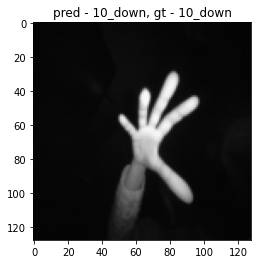

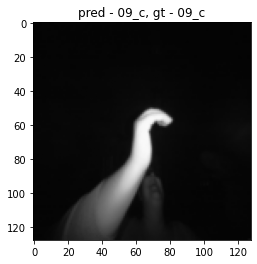

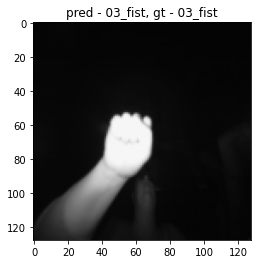

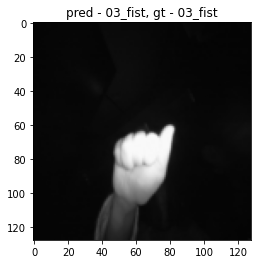

In [82]:
with torch.no_grad():
    for i, data in enumerate(test_dl, 3):
        images, labels = data[0].to(device), data[1].to(device)
        
        outputs = resnet(images)
        plt.title(f'pred - {digit_to_classname(outputs[0].argmax())}, gt - {digit_to_classname(labels[0])}')
        plt.imshow(images[0].cpu().permute(1, 2, 0), cmap='gray')
        plt.show()
        if i>5:
            break

Результаты неплохие

Сохраним и скачаем нашу модель:

In [83]:
torch.save(resnet, 'model/checkpoint_91')

"C:\Users\s2e\23_GB_M17_PyTorch_JP+ML\model"

In [84]:
resnet = torch.load('model/checkpoint_91')
resnet.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

попробуем достичь лучшего результата, обучая нейросеть еще на одной эпохе :

In [85]:
resnet, train_losses, val_losses = train(
    model=resnet,
    criterion=criterion,
    optimizer=optimizer,
    train_dataloader=train_dl,
    test_dataloader=test_dl,
    print_every=print_every,
    num_epoch=1
)

Epoch [1]/[1]. Batch [50]/[250]. Train loss 0.252. Train acc 92.000. Val loss 0.361. Val acc 91.050. Took 234.136 seconds
Epoch [1]/[1]. Batch [100]/[250]. Train loss 0.231. Train acc 92.719. Val loss 0.361. Val acc 91.050. Took 216.359 seconds
Epoch [1]/[1]. Batch [150]/[250]. Train loss 0.229. Train acc 92.812. Val loss 0.361. Val acc 91.050. Took 215.198 seconds
Epoch [1]/[1]. Batch [200]/[250]. Train loss 0.229. Train acc 92.812. Val loss 0.361. Val acc 91.050. Took 214.437 seconds
Epoch [1]/[1]. Batch [250]/[250]. Train loss 0.226. Train acc 92.906. Val loss 0.361. Val acc 91.050. Took 212.183 seconds
Epoch took 1092.60968375206


похоже вышли на плато, но по валидационному датасету уверенно выше 91% accuracy

Далее надо сделать блок работы с фото, но у меня уже не хватет времени

In [86]:
!pip install facenet_pytorch

In [87]:
!pip install mediapipe

  Using cached mediapipe-0.10.1-cp39-cp39-win_amd64.whl (50.2 MB)
  Using cached opencv_contrib_python-4.7.0.72-cp37-abi3-win_amd64.whl (44.9 MB)
  Using cached sounddevice-0.4.6-py3-none-win_amd64.whl (199 kB)


ERROR: Could not install packages due to an OSError: [WinError 5] Отказано в доступе: 'C:\\Users\\s2e\\anaconda3\\Lib\\site-packages\\cv2\\cv2.pyd'
Consider using the `--user` option or check the permissions.

